[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/jcGourcuff/Uliege/blob/master/BoxClassifier.ipynb)

# Imports

### Librairies


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torchvision
from torchvision import models,transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from google.colab import files
import os
import glob
%matplotlib inline

### Data

In [ ]:
!git clone https://github.com/jcGourcuff/customNILMdataSet.git

Cloning into 'customNILMdataSet'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 33844 (delta 1), reused 261 (delta 0), pack-reused 33582
Receiving objects: 100% (33844/33844), 981.23 MiB | 54.18 MiB/s, done.
Resolving deltas: 100% (33232/33232), done.
Checking out files: 100% (33772/33772), done.


In [ ]:
!ls

customNILMdataSet  sample_data


In [ ]:
root_dir = 'customNILMdataSet/NILM_image_DataSet/'

# Set up



### Class encoding



In [ ]:
classes_modes = {'all' : ['residuals', 'oven', 'refrigerator', 'dishwasher', 'kitchen_outlets', 'lighting', 'washer_dryer', 'microwave', 'bathroom_gfi'],
                 'minimal' : ['refrigerator', 'dishwasher', 'lighting', 'washer_dryer'],
                 'minimal_plus_kitchen' : ['refrigerator', 'dishwasher', 'lighting', 'washer_dryer', 'kitchen_outlets'],
                 'hybrid' : ['oven', 'refrigerator', 'dishwasher', 'kitchen_outlets', 'lighting', 'washer_dryer', 'microwave', 'bathroom_gfi']}
classes = classes_modes['minimal']
lab_encoder= OneHotEncoder(sparse = False)
lab_encoder.fit([[name] for name in classes])
lab_encoder.categories_

[array(['dishwasher', 'lighting', 'refrigerator', 'washer_dryer'],
       dtype=object)]

In [ ]:
def get_encoding_index_corespondances():
    result = {}
    for cls in classes :
      encoding = lab_encoder.transform([[cls]])[0]
      result[str(np.argmax(encoding))] = cls
    return result

### Id selection

Here we select the indexes relevant to our ML task. It includes class selection, samples homogeneisation and/or downsampling for the over represented classes. 

In [ ]:
def import_labels(nb_apps):
  """
  nb_apps list or digit
  """
  if type(nb_apps) == list :
    result = []
    for i in nb_apps :
      result.append(import_labels(i))
    return pd.concat(result, axis = 0)
  else :
    return pd.read_csv(root_dir + str(nb_apps) + '_apps/labels.csv', compression = 'zip').set_index('id')
  
def class_select(labels):
    mask = (labels['label']==classes[0])
    for cls in classes[1:]:
      mask = mask | (labels['label']==cls)
    return labels[mask]
    
def downsampling(labels, max_over_rep = 1.3):
    nbs = [np.sum(labels['label']== cls) for cls in classes]
    cls_min = classes[np.argmin(nbs)]
    result =  labels[labels['label'] == cls_min]
    for cls in classes  :
      if cls != cls_min :
        df = labels[labels['label']==cls]
        df = df.loc[np.random.choice(df.index, size = min(int(min(nbs)*1.3),df.shape[0]) , replace = False)]
        result = pd.concat([result, df], axis = 0)
    return result


Here we define a few functions to keep relevant examples, that is limiting the 'small boxes'.

In [ ]:
def prob(lamb, pow):
    def f(x):
        return np.power(x/lamb, pow)*(pow+1)/lamb
    return f

def sample_from(ids, values, law):
    """
    Samples input such that frequency obeys at max the law.
    """
    result = []
    for id, value in zip(ids, values) :
        if np.random.random() <= law(value) :
            result.append(id)
    return result

def filter_ids(tresh, data):
    loi = prob(tresh, int(np.sqrt(tresh)))
    to_keep = list(data.index[data['area']>tresh])
    for cls in classes :
      to_keep = to_keep + sample_from(data.index[ (data['label'] == cls) & (data['area']<=tresh)], data[data['area']<=tresh]['area'], loi)
    return data.loc[to_keep]

### Data set embedding

In [ ]:
class BoxDataSet(Dataset):

    def __init__(self, transform, encoder, batch_size, data = None, nb_app = None):
        self.labels = 0
        if data is None :
            self.labels = pd.read_csv(root_dir + str(nb_app) + '_apps/labels.csv', compression = 'zip').set_index('id')
        else :
            self.labels = data
        self.encoder = encoder
        self.transform = transform
        self.nb_app = nb_app

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        id = self.labels.index[idx]
        label = torch.FloatTensor(self.encoder.transform([[self.labels.loc[id,'label']]])[0])
        img = self.extract_img(id)

        sample = {'id':id,'image':img,'label':label}

        return sample

    def extract_img(self, img_id):
        img_name = self.find(str(img_id) + '.png', root_dir)
        try:
          img = Image.open(img_name) # open the image file
          img.verify() # verify that it is, in fact an image
          img.close()
        except (IOError, SyntaxError) as e:
          print('Bad file:', img_name)
        img =  np.array(Image.open(img_name).convert("RGB"))
        img = torch.as_tensor(self.transform(img))[:,-4850:,:]
        return img

    def find(self, name, path):
        for root, _, files in os.walk(path):
            if name in files:
                return os.path.join(root, name)

#### Data preprocessing

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_image = transforms.Compose([transforms.ToTensor(),normalize])

#### Vizualisation

In [ ]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.figure(figsize = (40,8) )
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#### Test data loading

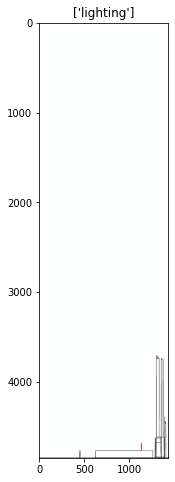

In [ ]:
test_set = BoxDataSet(transform=transform_image, encoder = lab_encoder, batch_size = 1, nb_app=2)
test_loader = DataLoader(test_set, batch_size = 1, shuffle=True, num_workers = 1)

batch_test = next(iter(test_loader))
out = torchvision.utils.make_grid(batch_test['image'])
imshow(out, title=[lab_encoder.inverse_transform([batch_test['label'][x].numpy()])[0][0]for x in range(1)])

### Using GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Features precomputing


In [ ]:
#Model used for computing the features
pretrained_model = models.resnet50(pretrained = True).to(device)
pretrained_model_feats = nn.Sequential(*list(pretrained_model.children())[:-1])
for param in pretrained_model_feats.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
def preconvfeat(data):
    inputs = data['image'].to(device)
    labels = data['label'].to(device)
    ids = data['id'].to(device)
    x = pretrained_model_feats(inputs)
    return x.data.cpu().numpy(), labels.data.cpu().numpy(), ids.data.cpu().numpy()



In [ ]:
def get_precomputed_dset(nb_app, num_file = 1, save = False):
    dset = BoxDataSet(transform=transform_image, encoder = lab_encoder, batch_size = 1, nb_app = nb_app)
    loader = DataLoader(dset, batch_size = 1, shuffle= False, num_workers = 1)
    print("Precomputing features...")

    conv_features = []
    labels_list = []
    ids_list = []

    N = len(loader)
    sub_file_size = N//num_file

    k=  1
    i = 1
    for data in loader:
        print("\r {}%".format(np.round(100*k/N, decimals = 2)), end  = '')

        feats, labs, ids = preconvfeat(data)
        conv_features.extend(feats)
        labels_list.extend(labs)
        ids_list.extend(ids)


        if save and k%sub_file_size == 0 :
            conv_features = np.concatenate([[feat] for feat in conv_features])
            datasetfeat = [[torch.from_numpy(f).type(torch.float),torch.tensor(l).type(torch.float), i] for (f,l,i) in zip(conv_features, labels_list, ids_list)]
            datasetfeat = [(inputs.reshape(-1), labels, ids) for [inputs,labels, ids] in datasetfeat]
            features = pd.DataFrame([f[0] for f in datasetfeat]).astype(float)
            ids = pd.Series([f[2] for f in datasetfeat])
            to_save = pd.concat([features, ids], axis = 1)
            to_save.columns = list(to_save.columns[:-1])+['id']
            file_name = "precomputed_ResNet50_"+str(nb_app) + "apps_part"+str(i)+".csv"
            to_save.to_csv(file_name, index = False, compression = 'zip')
            #files.download(file_name)

            i+=1
            conv_features = []
            labels_list = []
            ids_list = []

        k+=1

    if save :
        if len(conv_features)!= 0 :
            conv_features = np.concatenate([[feat] for feat in conv_features])
            datasetfeat = [[torch.from_numpy(f).type(torch.float),torch.tensor(l).type(torch.float), i] for (f,l,i) in zip(conv_features, labels_list, ids_list)]
            datasetfeat = [(inputs.reshape(-1), labels, ids) for [inputs,labels, ids] in datasetfeat]
            features = pd.DataFrame([f[0] for f in datasetfeat]).astype(float)
            ids = pd.Series([f[2] for f in datasetfeat])
            to_save = pd.concat([features, ids], axis = 1)
            to_save.columns = list(to_save.columns[:-1])+['id']
            file_name = "precomputed_ResNet50_"+str(nb_app) + "apps_part"+str(i)+".csv"
            to_save.to_csv(file_name, index = False, compression = 'zip')
            #files.download(file_name)
        return 0

    else :
        conv_features = np.concatenate([[feat] for feat in conv_features])
        datasetfeat = [[torch.from_numpy(f).type(torch.float),torch.tensor(l).type(torch.float), i] for (f,l,i) in zip(conv_features, labels_list, ids_list)]
        datasetfeat = [(inputs.reshape(-1), labels, ids) for [inputs,labels, ids] in datasetfeat]
        return datasetfeat


In [ ]:
def find(name, path):
        for root, _, files in os.walk(path):
            if name in files:
                return os.path.join(root, name)

def load_precomputed_dset(model, nb_app = None):
    mother_dir = root_dir + "Precomputed_feats/"

    if model == "resnet18" :
      
      file_name = find("precomputed_ResNet18_2apps.csv", root_dir)

      if file_name is not None :
        df =  pd.read_csv(file_name, compression = 'zip').set_index('id')
        labels = pd.read_csv(root_dir + str(2) + '_apps/labels.csv', compression = 'zip').set_index('id')
        df['label'] = labels.loc[df.index, 'label']
        return df
      else :
        %cd customNILMdataSet/Precomputed_feats/precomputed_ResNet18_2apps/
        !cat precomputed_ResNet18_2apps.csv.part* > precomputed_ResNet18_2apps.csv
        %cd ../../..
        return load_precomputed_dset("resnet18")

    if model == "resnet50" :

      if type(nb_app) == list :
        return pd.concat([load_precomputed_dset(model,x) for x in nb_app], axis = 0)

      else :
        mother_dir = mother_dir + "resnet_50/" + str(nb_app) + "_apps/"
        files = glob.glob(mother_dir + "*.csv")
        dfs = []
        for f in files :
          df = pd.read_csv(f, compression = 'zip').set_index('id')
          labels = pd.read_csv(root_dir + str(nb_app) + '_apps/labels.csv', compression = 'zip').set_index('id')
          df['label'] = labels.loc[df.index, 'label']
          dfs.append(df)
        return pd.concat(dfs, axis = 0)

def convert_to_usable_dset(df):
    labels = [torch.tensor(lab_encoder.transform([[lab]])[0]).type(torch.float) for lab in df['label']]
    del df['label']
    inputs = [torch.from_numpy(df.loc[idx].to_numpy()).type(torch.float) for idx in df.index]
    return [(f,l,id) for f,l,id in zip(inputs, labels, df.index)]

# Model creation

In [ ]:
class BoxNet(nn.Module):
    
    def __init__(self, output_size):
        super(BoxNet, self).__init__()
        self.output_size = output_size

        self.res_1 = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(2048))
        
        self.res_2 = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(2048))
        
        self.res_3 = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(2048))
        
        self.res_4 = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(2048))
        
        self.res_5 = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(2048))


        self.fc = nn.Sequential(nn.Dropout(inplace=False),
                                nn.Linear(2048, self.output_size))
                                

    def forward(self, x):
        x = x + self.res_1(x)
        x = x + self.res_2(x)
        x = x + self.res_3(x)
        x = x + self.res_4(x)
        x = x + self.res_5(x)
        x = self.fc(x)
        return x

# Training and testing loops

## Training

In [ ]:
def train_model(model,dataloader,size,epochs=1,optimizer=None, scheduler = None):
    model.train()
    batch_count = 1
    loss_mem = []
    acc_mem = []
    lr_mem = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, targets,_ in dataloader:
            #print("\rbatch {}".format(batch_count), end = '')
            batch_count+=1
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _,preds = torch.max(F(outputs.data),1)
            # statistics
            running_loss += loss.data.item()
            _,classs =  torch.max(targets,1)
            running_corrects += torch.sum(preds == classs)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        loss_mem.append(epoch_loss)
        acc_mem.append(epoch_acc)

        scheduler.step(epoch_loss)
        lr_mem.append(optimizer.param_groups[0]['lr'])

        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return loss_mem, acc_mem, lr_mem

## Testing

In [ ]:
def evaluate(target, source):
        """
        Evaluates on all classic metrics the performances of a binary classification.
        """
        tn, fp, fn, tp = confusion_matrix(target, source).ravel()
        acc = (tp+tn)/(tn+fp+fn+tp)
        rec = tp/(tp+fn)
        pre = tp/(tp+fp)
        spe = tn/(tn+fp)
        f1 = (2*pre*rec)/(pre+rec)
        result = pd.Series([acc,rec,pre,spe,f1])
        result.index = ['Acc', 'Rec', 'Pre', 'Spe', 'F1']

        mat = pd.DataFrame(confusion_matrix(target, source))
        mat.columns = pd.MultiIndex(levels = [['Actual'],['Negatives','Positives']], codes = [[0,0],[0,1]])
        mat.index = pd.MultiIndex(levels = [['Prediction'],['Negatives','Positives']], codes = [[0,0],[0,1]])
        dfStyler = mat.style.set_properties(**{'text-align': 'center'})
        dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

        return result, mat

In [ ]:
def test_model(model, dataloader, size):
    model.eval()
    predicted = []
    gtruth = []
    for inputs, targets,_ in dataloader:
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        _,preds = torch.max(F(outputs.data),1)
        _,classs =  torch.max(targets,1)
        predicted.extend(preds.data.cpu().numpy())
        gtruth.extend(classs.data.cpu().numpy())
        
    return predicted, gtruth

In [ ]:
def eval_predictions(preds, labels):

    #stats_per_app
    result_per_app = []
    encoding_cores = get_encoding_index_corespondances()
    for k in pd.Series(labels).drop_duplicates() :
        app_name = encoding_cores[str(k)]
        source = (np.array(preds) == k)*1
        target = (np.array(labels)== k)*1
        metrics, conf_matrix = evaluate(target, source)
        result_per_app.append((app_name, metrics, conf_matrix))
    
    #overall_stats
    acc = np.sum(np.array(preds) == np.array(labels))
    print("Overall accuracy : {} ".format(acc/len(preds)))

    return result_per_app 

# Instanciating and training

In this section, we train and test our model as classic claffication model, without taking into account the achieved reconstituted energy.

In [ ]:
nb_outputs_ = len(classes)

In [ ]:
BoxModel = BoxNet(nb_outputs_)

In [ ]:
F = nn.Sigmoid().to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
batch_size_ = 128
lr_ = 0.01
optimizer = torch.optim.Adam(BoxModel.parameters(), lr=lr_)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
BoxModel.to(device)

BoxNet(
  (res_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_4): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
datas = pd.concat([import_labels(k) for k in range(2,8)], axis = 0)
datas = class_select(datas)
datas = filter_ids(tresh = 100, data = datas)
datas = downsampling(datas, max_over_rep= 1.3)
print(datas.shape)

(11211, 2)


In [ ]:
resnet50 = load_precomputed_dset("resnet50", nb_app = [k for k in range(2,8)])
resnet50 = resnet50.loc[datas.index.intersection(resnet50.index)]
resnet50 = convert_to_usable_dset(resnet50)
np.random.shuffle(resnet50)

In [ ]:
train_2apps = resnet50[:int(len(resnet50)*0.8)]
valid_2apps = resnet50[int(len(resnet50)*0.8):]

In [ ]:
trainLoader_2apps = DataLoader(train_2apps, batch_size = batch_size_ , shuffle = True, drop_last = True)
validLoader_2apps = DataLoader(valid_2apps, batch_size = batch_size_, shuffle = False, drop_last = True)

In [ ]:
loss_mem, acc_mem, lr_mem = train_model(BoxModel,dataloader = trainLoader_2apps, size = len(train_2apps),epochs=500,optimizer=optimizer, scheduler = scheduler)

Loss: 0.0110 Acc: 0.3176
Loss: 0.0068 Acc: 0.3485
Loss: 0.0063 Acc: 0.3591
Loss: 0.0063 Acc: 0.3617
Loss: 0.0055 Acc: 0.3861
Loss: 0.0051 Acc: 0.3874
Loss: 0.0049 Acc: 0.3878
Loss: 0.0049 Acc: 0.3910
Loss: 0.0048 Acc: 0.3924
Loss: 0.0046 Acc: 0.4134
Loss: 0.0044 Acc: 0.4204
Loss: 0.0044 Acc: 0.4291
Loss: 0.0044 Acc: 0.4218
Loss: 0.0042 Acc: 0.4347
Loss: 0.0043 Acc: 0.4367
Loss: 0.0041 Acc: 0.4485
Loss: 0.0042 Acc: 0.4446
Loss: 0.0042 Acc: 0.4508
Loss: 0.0041 Acc: 0.4611
Loss: 0.0040 Acc: 0.4677
Loss: 0.0040 Acc: 0.4776
Loss: 0.0040 Acc: 0.4773
Loss: 0.0040 Acc: 0.4830
Loss: 0.0039 Acc: 0.5022
Loss: 0.0038 Acc: 0.5067
Loss: 0.0038 Acc: 0.5131
Loss: 0.0037 Acc: 0.5350
Loss: 0.0037 Acc: 0.5408
Loss: 0.0036 Acc: 0.5504
Loss: 0.0036 Acc: 0.5545
Loss: 0.0035 Acc: 0.5748
Loss: 0.0035 Acc: 0.5697
Loss: 0.0036 Acc: 0.5688
Loss: 0.0035 Acc: 0.5787
Loss: 0.0034 Acc: 0.5830
Loss: 0.0033 Acc: 0.6067
Loss: 0.0034 Acc: 0.5921
Loss: 0.0033 Acc: 0.6055
Loss: 0.0033 Acc: 0.6035
Loss: 0.0034 Acc: 0.5958


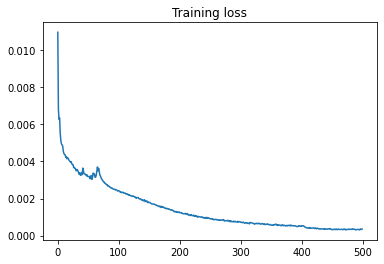

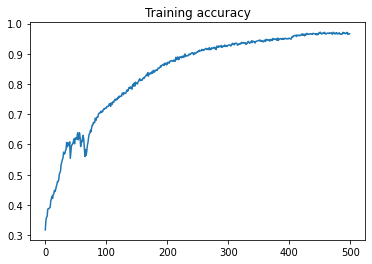

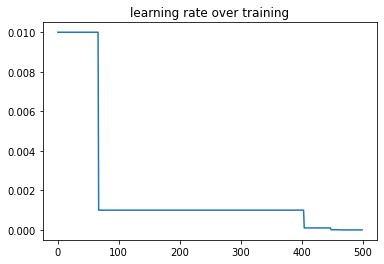

In [ ]:
plt.plot(np.arange(len(loss_mem)),loss_mem)
plt.title("Training loss")
plt.show()
plt.plot(np.arange(len(acc_mem)),acc_mem)
plt.title("Training accuracy")
plt.show()
plt.plot(np.arange(len(lr_mem)), lr_mem)
plt.title("learning rate over training")
plt.show()

In [ ]:
predic, gt = test_model(BoxModel, dataloader = validLoader_2apps, size = len(valid_2apps))

In [ ]:
res_per_app = eval_predictions(predic, gt)

Overall accuracy : 0.8391544117647058 


In [ ]:
for name, metrics, conf_mat in res_per_app: 
  print(name)
  print(metrics)
  print(conf_mat)
  print('\n')

lighting
Acc    0.924173
Rec    0.802083
Pre    0.846154
Spe    0.958726
F1     0.823529
dtype: float64
                        Actual          
                     Negatives Positives
Prediction Negatives      1626        70
           Positives        95       385


washer_dryer
Acc    0.929228
Rec    0.817805
Pre    0.856833
Spe    0.961016
F1     0.836864
dtype: float64
                        Actual          
                     Negatives Positives
Prediction Negatives      1627        66
           Positives        88       395


refrigerator
Acc    0.920496
Rec    0.888342
Pre    0.837461
Spe    0.932993
F1     0.862151
dtype: float64
                        Actual          
                     Negatives Positives
Prediction Negatives      1462       105
           Positives        68       541


dishwasher
Acc    0.904412
Rec    0.836093
Pre    0.822476
Spe    0.930662
F1     0.829228
dtype: float64
                        Actual          
                     Negatives Posi

# Saving model

Now we can save our model and use it on any unseen data.

In [ ]:
model_save_path = root_dir + "boxnet_state_dict.pt"

In [ ]:
torch.save(BoxModel.cpu().state_dict(), model_save_path)

In [ ]:
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>